In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import pandas as pd
from pandas.io.formats.style import Styler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

import os
import sys
import datetime
from tqdm import tqdm
import copy

import optuna
import wandb
from wandb.lightgbm import wandb_callback, log_summary

import xgboost as xgb
from xgboost.callback import EarlyStopping
import lightgbm as lgbm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, BayesianRidge
from sklearn.calibration import CalibratedClassifierCV

from umap import UMAP

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
from src.data_processing.fi import get_fi
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

In [14]:
from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

rc = {
    "axes.facecolor": "#FFFEF8",
    "figure.facecolor": "#FFFEF8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

In [15]:
orig = pd.read_csv(os.path.join(CFG.RAW_DATA, 'Pulsar.csv'))
train = pd.read_csv(os.path.join(CFG.RAW_DATA, 'train.csv')).drop(columns='id')
test = pd.read_csv(os.path.join(CFG.RAW_DATA, 'test.csv')).drop(columns='id')

config = {}

In [36]:
scaler = StandardScaler()
config['scaler'] = "standard"

scaled_tr = pd.DataFrame(scaler.fit_transform(train.drop("Class", axis=1)), columns=train.drop("Class", axis=1).columns)
scaled_tr["Class"] = train["Class"]

scaled_orig = pd.DataFrame(scaler.fit_transform(orig.drop("Class", axis=1)), columns=orig.drop("Class", axis=1).columns)
scaled_orig["Class"] = orig["Class"]

scaled_tst = pd.DataFrame(scaler.transform(test), columns=test.columns)

In [37]:
def get_n_components(df):
    n_components = df.shape[1]
    pca = PCA(n_components=n_components, random_state=CFG.SEED)
    
    components = pca.fit_transform(df)
    components = pd.DataFrame(components, columns=[f'PC{i}' for i in range(n_components)])
    components['Class'] = df['Class']
    exp_var = pca.explained_variance_ratio_
    exp_var_cumsum = np.cumsum(exp_var)
    return components, exp_var, exp_var_cumsum

In [38]:
components, exp_var, exp_var_cumsum = get_n_components(scaled_tr)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(range(len(exp_var_cumsum))),
        y=exp_var_cumsum,
        name='Cumulative Explained Variance',
        line=dict(color=palette[0], width=2),
    )
)
fig.add_trace(
    go.Bar(
        x=list(range(len(exp_var_cumsum))),
        y=exp_var,
        name='Explained Variance',
        marker_color=palette[1],
        width=0.7,
    )
)

fig.update_layout(
    xaxis=dict(title='Principal Components', titlefont_size=20, tickfont_size=16),
    yaxis=dict(title='Explained Variance', titlefont_size=20, tickfont_size=16),
    height=500, width=1000, title_text='Explained Variance by Principal Components', title_x=0.5, titlefont_size=24,
)

- I will try using 3 components first, then maybe 4

In [39]:
def pca_transform(train, test, N):
    pca = PCA(n_components=N, random_state=CFG.SEED)
    X = pca.fit_transform(train.drop("Class", axis=1))
    X = pd.DataFrame(X, columns=[f'PC{i}' for i in range(N)])
    y = train['Class']
    return pca.transform(test), X, y

In [44]:
N = 3
config['n_components'] = N

X_test, X, y = pca_transform(scaled_tr, scaled_tst, N)

In [21]:
k_fold = RepeatedStratifiedKFold(n_splits=CFG.NFOLDS, n_repeats=CFG.REPEATS, random_state=CFG.SEED)

modelsXB = []
predsXB = []

# gpu_params = {'tree_method' : "gpu_hist", 'gpu_id' : 0}
xgbr_params = {
            'n_estimators':9999,
            'max_depth': 4,
            'learning_rate': 0.05333221939055333,
            'min_child_weight': 4,
            'gamma': 5.301218558776368e-08,
            'subsample': 0.41010429946197946,
            'colsample_bytree': 0.8298539920447499,
            'reg_alpha': 0.000517878113716743,
            'reg_lambda': 0.00030121415155097723,
            'n_jobs': -1,
            'objective': 'binary:logistic',
            'verbosity': 0,
            'eval_metric': 'logloss',
            'random_state': CFG.SEED}

config.update({key:val for key, val in xgbr_params.items() if key not in ['random_state', 'eval_metric', 'verbosity', 'objective', 'n_jobs']})
wandb.init(project='S3E10', name='XGBoost', group='XGBoost', config=config, dir=CFG.BASE_PATH)

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = xgb.XGBClassifier(**xgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = CFG.XG_PATIENCE,
          verbose = 100, callbacks=[wandb.xgboost.WandbCallback(log_model=False)]
         )
    modelsXB.append(model)
    predsXB.append(model.predict_proba(X_test)[:, 1])

best_iteration,▃▅▄▂█▂▄▁
best_score,▁▇▇▄▄█▃█
epoch,▁▃▄▅▇▂▃▅▆▇▂▄▅▆▁▃▄▅▁▂▄▅▇█▂▃▅▆▂▃▅▆▇▂▄▅▆▂▃▅
validation_0-logloss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_iteration,733
best_score,0.0409
epoch,628


[0]	validation_0-logloss:0.64366
[100]	validation_0-logloss:0.04621
[200]	validation_0-logloss:0.04008
[300]	validation_0-logloss:0.03861
[400]	validation_0-logloss:0.03781
[500]	validation_0-logloss:0.03729
[600]	validation_0-logloss:0.03690
[700]	validation_0-logloss:0.03683
[800]	validation_0-logloss:0.03670
[868]	validation_0-logloss:0.03672
[0]	validation_0-logloss:0.64369
[100]	validation_0-logloss:0.04943
[200]	validation_0-logloss:0.04405
[300]	validation_0-logloss:0.04289
[400]	validation_0-logloss:0.04201
[500]	validation_0-logloss:0.04154
[600]	validation_0-logloss:0.04116
[700]	validation_0-logloss:0.04085
[800]	validation_0-logloss:0.04070
[900]	validation_0-logloss:0.04051
[933]	validation_0-logloss:0.04051
[0]	validation_0-logloss:0.64362
[100]	validation_0-logloss:0.04864
[200]	validation_0-logloss:0.04367
[300]	validation_0-logloss:0.04260
[400]	validation_0-logloss:0.04177
[500]	validation_0-logloss:0.04137
[600]	validation_0-logloss:0.04116
[700]	validation_0-logloss

In [26]:
feature_importance =  [modelsXB[x].feature_importances_ for x in range(CFG.NFOLDS*CFG.REPEATS)]
feature_importance = np.average(feature_importance,axis=0)
data = [[label, value] for (label, value) in zip(X.columns, feature_importance)]

table = wandb.Table(data=data, columns=['label', 'value'])
wandb.log({'XGBoost_Feature_Importance': wandb.plot.bar(table, 'label', 'value', title="Feature Importance")})
# feature_df = pd.DataFrame(feature_importance, index=X.columns)
# feature_df
# wandb.Table

# fig, ax = plt.subplots(figsize=(12, 4))
# sns.barplot(x=feature_df.values.squeeze(), y=feature_df.index,
#             color=palette[-3], linestyle="-", width=0.5, errorbar='sd',
#             linewidth=0.5, edgecolor="black", ax=ax)
# ax.set_title('Feature Importance', fontdict={'fontweight': 'bold'})
# ax.set(xlabel=None)

# for s in ['right', 'top']:
#     ax.spines[s].set_visible(False)

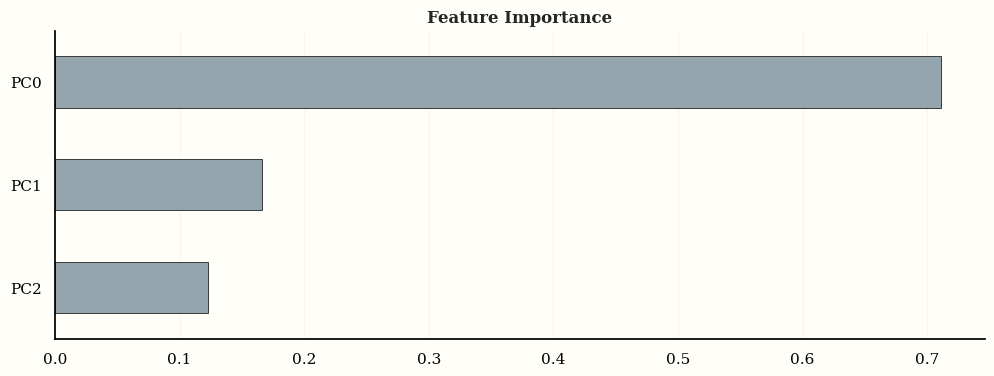

In [11]:
get_fi(modelsXB, X, CFG)

In [33]:
modelsLB = []
predsLB = []

lgbr_params = {
            'n_estimators': 9999,
            'max_depth': 5,
            'learning_rate': 0.00693702575527996,
            'subsample': 0.20851841295589477,
            'colsample_bytree': 0.5784778854092203, 
            'reg_alpha': 0.2622912287429849,
            'reg_lambda': 2.8702494234117617e-08,
            'objective': 'binary',
            'metric': 'logloss',
            'boosting_type': 'gbdt',
            'random_state': CFG.SEED
        }
config = {} | {
    key: value for key, value in lgbr_params.items() if key not in ['']
}
wandb.init(project='S3E10', name='LightGBM', group='LightGBM', config=config, reinit=True)

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

    model = lgbm.LGBMClassifier(**lgbr_params)

    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          eval_metric = 'logloss',
          early_stopping_rounds = CFG.XG_PATIENCE,
          verbose = 150,
          callbacks=[wandb_callback()]
         )
    modelsLB.append(model)
    predsLB.append(model.predict_proba(X_test)[:, 1])

[150]	valid_0's binary_logloss: 0.0953115
[300]	valid_0's binary_logloss: 0.0578285
[450]	valid_0's binary_logloss: 0.0465859
[600]	valid_0's binary_logloss: 0.0429607
[750]	valid_0's binary_logloss: 0.0417193
[900]	valid_0's binary_logloss: 0.0412125
[1050]	valid_0's binary_logloss: 0.0408657
[1200]	valid_0's binary_logloss: 0.0406281
[1350]	valid_0's binary_logloss: 0.0404454
[1500]	valid_0's binary_logloss: 0.0403004
[1650]	valid_0's binary_logloss: 0.040134
[1800]	valid_0's binary_logloss: 0.039977
[1950]	valid_0's binary_logloss: 0.0398348
[2100]	valid_0's binary_logloss: 0.0397093
[2250]	valid_0's binary_logloss: 0.0396199
[2400]	valid_0's binary_logloss: 0.0395487
[2550]	valid_0's binary_logloss: 0.0394833
[2700]	valid_0's binary_logloss: 0.0393988
[2850]	valid_0's binary_logloss: 0.0393578
[3000]	valid_0's binary_logloss: 0.0393198
[3150]	valid_0's binary_logloss: 0.0392504
[150]	valid_0's binary_logloss: 0.0974361
[300]	valid_0's binary_logloss: 0.0609198
[450]	valid_0's binar

In [34]:
feature_importance =  [modelsLB[x].feature_importances_ for x in range(CFG.NFOLDS*CFG.REPEATS)]
feature_importance = np.average(feature_importance,axis=0)
data = [[label, value] for (label, value) in zip(X.columns, feature_importance)]

table = wandb.Table(data=data, columns=['label', 'value'])
wandb.log({'LGBM_Feature_Importance': wandb.plot.bar(table, 'label', 'value', title="Feature Importance")})

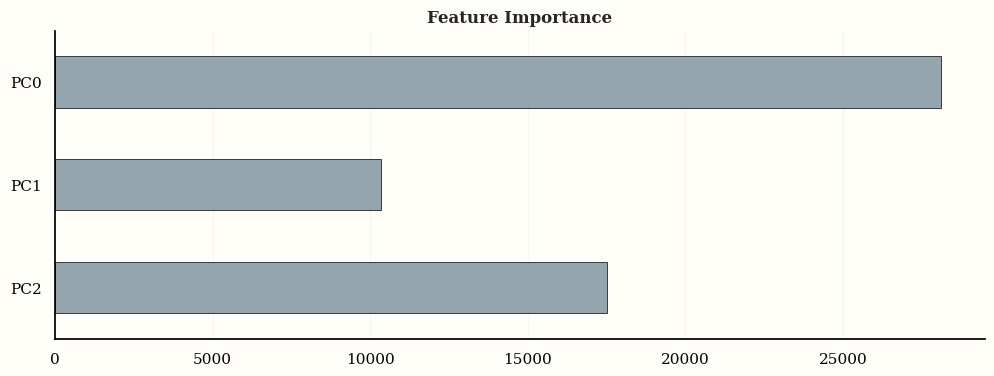

In [13]:
get_fi(modelsLB, X, CFG)

In [45]:
modelsRF = []
predsRF = []

params = {
        'criterion': 'log_loss',
        'n_jobs': -1,
        'random_state': CFG.SEED,
        'verbose': False,
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'min_weight_fraction_leaf': 0.0,
        'max_features': 'sqrt',
        'max_leaf_nodes': None,
        'min_impurity_decrease': 0.0,
        'bootstrap': True,
        'max_samples': None
    }

config = {} | {
    key:value for key, value in params.items() if key not in ['criterion', 'n_jobs', 'random_state', 'verbose', 'bootstrap']
}
wandb.init(project='S3E10', name='RandomForest', group='RandomForest', config=config, reinit=True, dir=CFG.BASE_PATH)

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestClassifier(**params)
    model.fit(X=X_train, y=y_train)
    yprobas = model.predict_proba(X_valid)
    ypred = model.predict(X_valid)
    score = log_loss(y_valid, ypred)
    print(f'Score: {score}')
    
    modelsRF.append(model)
    predsRF.append(model.predict_proba(X_test)[:, 1])
    wandb.sklearn.plot_classifier(model, 
                               X_train, X_valid, 
                               y_train, y_valid,
                               ypred, yprobas,
                               [0, 1],
                               is_binary=True, 
                               model_name='RandomForest')

wandb: 
wandb: Plotting RandomForest.
wandb: Logged feature importances.


Score: 0.38813978080553857


wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RandomForest.
wandb: Logged feature importances.


Score: 0.4028559810256538


wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RandomForest.
wandb: Logged feature importances.


Score: 0.4010164559981394


wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RandomForest.
wandb: Logged feature importances.


Score: 0.3743433430991806


wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RandomForest.
wandb: Logged feature importances.


Score: 0.38078168069548096


wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RandomForest.
wandb: Logged feature importances.


Score: 0.4056152685669255


wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RandomForest.
wandb: Logged feature importances.


Score: 0.3835409682367526


wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RandomForest.
wandb: Logged feature importances.


Score: 0.41665241873201186


wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RandomForest.
wandb: Logged feature importances.


Score: 0.3706642930441518


wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [46]:
wandb.finish()

In [47]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [67]:
def fit_linear(X, y, test, model, name):
    models = []
    preds = []

    for train_index, test_index in k_fold.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
        
        #model = model(**params)
        model.fit(X=X_train, y=y_train)
        yprobas = model.predict_proba(X_valid)
        ypred = model.predict(X_valid)
        score = log_loss(y_valid, ypred)
        print(f'Score: {score}')
        
        models.append(model)
        preds.append(model.predict_proba(test)[:, 1])
        wandb.sklearn.plot_classifier(model, 
                                X_train, X_valid, 
                                y_train, y_valid,
                                ypred, yprobas,
                                [0, 1],
                                is_binary=True, 
                                model_name=name)
    return models, preds

In [73]:
lr_params = {
    'random_state': CFG.SEED,
    'max_iter': 10000,
    'n_jobs': -1,
    'solver': 'lbfgs',
    'C': 0.1,
    'tol': 1e-3
}
wandb.init(project='S3E10', name='LogisticRegression', group='LogisticRegression', config=lr_params, reinit=True, dir=CFG.BASE_PATH)
lr = LogisticRegression(**lr_params)
modelsLR, predsLR = fit_linear(X, y, X_test, lr, 'LogisticRegression')
wandb.finish()

wandb: 
wandb: Plotting LogisticRegression.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5399005955754766


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting LogisticRegression.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5638144209331639


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting LogisticRegression.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.555536558309349


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting LogisticRegression.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5316227329516618


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting LogisticRegression.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5399005955754765


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting LogisticRegression.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5895677713183655


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting LogisticRegression.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.550937745740563


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting LogisticRegression.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5702527585294642


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting LogisticRegression.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5399005955754765


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [76]:
r_params = {
    'random_state': CFG.SEED,
    'max_iter': 10000,
    'alpha': 0.1,
    'tol': 1e-3
}
wandb.init(project='S3E10', name='RidgeClassifier', group='RidgeClassifier', config=r_params, reinit=True, dir=CFG.BASE_PATH)
r = RidgeClassifier(**r_params)
clf = CalibratedClassifierCV(r)
modelsR, predsR = fit_linear(X, y, X_test, clf, 'RidgeClassifier')
wandb.finish()

wandb: 
wandb: Plotting RidgeClassifier.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5822096712083078


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RidgeClassifier.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5895677713183654


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RidgeClassifier.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5950863464009085


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RidgeClassifier.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5656539459606783


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RidgeClassifier.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5840491962358222


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RidgeClassifier.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.6116420716485382


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RidgeClassifier.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5904875338321226


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RidgeClassifier.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5950863464009086


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting RidgeClassifier.
wandb: Logged feature importances.
wandb: Logged confusion matrix.


Score: 0.5794503836670363


wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [77]:
def coef_objective(trial):
    a = trial.suggest_float('a', 0.5, 1)
    b = trial.suggest_float('b', 0.5, 1)
    c = trial.suggest_float('c', 0, 1)
    d = trial.suggest_float('d', 0, 1)
    
    preds_eval = []
    for model in modelsXB:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resXB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLB:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resLB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLR:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resLR = np.average(np.array(preds_eval),axis=0)

    preds_eval = []
    for model in modelsR:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resR = np.average(np.array(preds_eval),axis=0)
    
    res1 =  (resXB * a + resLB * b + resLR * c + resR + d)/(a + b + c + d)
    res = log_loss(y, res1)
    return res

study = optuna.create_study(direction= 'minimize')

[I 2023-03-19 00:32:56,524] A new study created in memory with name: no-name-66006de4-7d19-4c10-9ae9-d0e4a93c4e9c


In [78]:
study.optimize(coef_objective, n_trials=150)
coef_dict = study.best_params
coef_dict

[I 2023-03-19 00:33:57,797] Trial 0 finished with value: 0.5111631287746657 and parameters: {'a': 0.561196375266751, 'b': 0.9673416005779559, 'c': 0.013563322393281507, 'd': 0.8801023945035454}. Best is trial 0 with value: 0.5111631287746657.
[I 2023-03-19 00:34:29,724] Trial 1 finished with value: 0.22871214348936977 and parameters: {'a': 0.5021538639798796, 'b': 0.6644291721192368, 'c': 0.8113441878241875, 'd': 0.31031059451546594}. Best is trial 1 with value: 0.22871214348936977.
[I 2023-03-19 00:35:01,346] Trial 2 finished with value: 0.3513420119654242 and parameters: {'a': 0.9559280070277311, 'b': 0.8484515338609904, 'c': 0.9466856990494894, 'd': 0.9634852055722679}. Best is trial 1 with value: 0.22871214348936977.
[I 2023-03-19 00:35:31,882] Trial 3 finished with value: 0.3307034380731156 and parameters: {'a': 0.9521277698969515, 'b': 0.9648397787955166, 'c': 0.8637085099302466, 'd': 0.890976634793375}. Best is trial 1 with value: 0.22871214348936977.
[I 2023-03-19 00:36:02,715]

{'a': 0.9988176363701954,
 'b': 0.9331494520585308,
 'c': 0.2930840889233804,
 'd': 5.371954926481682e-05}

In [79]:
predXB = np.average(np.array(predsXB),axis=0)
predLB = np.average(np.array(predsLB),axis=0)
predLR = np.average(np.array(predsLR),axis=0)
predR = np.average(np.array(predsR),axis=0)

pred = (predXB * coef_dict['a'] + predLB * coef_dict['b'] + predLR * coef_dict['c'] + predR * coef_dict['d']) / (coef_dict['a'] + coef_dict['b'] + coef_dict['c'] + coef_dict['d'])

In [80]:
submission = pd.read_csv(os.path.join(CFG.DATA_PATH, 'sample_submission.csv'))
submission['Class'] = pred
submission.to_csv(
    os.path.join(CFG.BASE_PATH, 'submissions', f'XG-LGB-LR-R_PCA-{datetime.datetime.strftime(datetime.datetime.now(), "%m-%d_%H-%M")}.csv'),
    index=False)

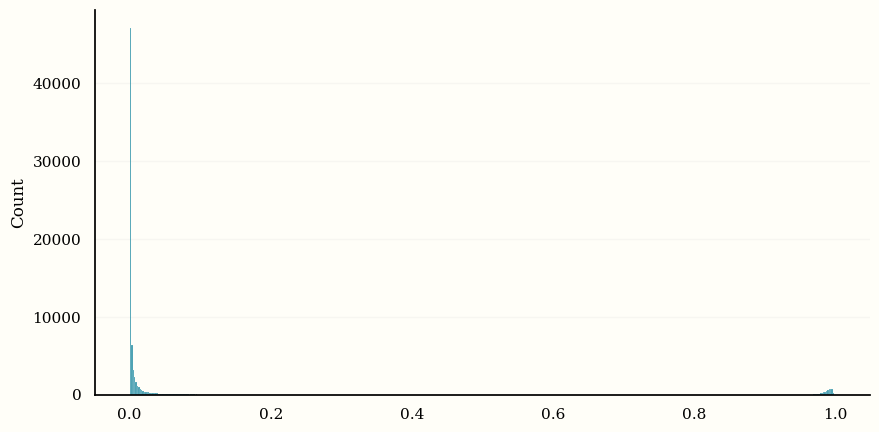

In [81]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(pred, bins=500, color=palette[1], ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(False)
ax.yaxis.grid(True)